# Generate the logo image for COOLEST

This notebook generates the COOLEST logo based on an actual lens model. It is inspired by the ["Cosmic Horseshoe"](https://esahubble.org/images/potw1151a/) strong gravitational lens observed with the _Hubble Space Telescope_. The code uses [lenstronomy](https://github.com/lenstronomy/lenstronomy) ([Birrer et al. 2021](https://ui.adsabs.harvard.edu/abs/2021JOSS....6.3283B/abstract)) to perform lensing computations, and is based on Figure 2.6 of [A. Galan's Ph.D dissertation](https://infoscience.epfl.ch/record/298015).

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
#plt.rc('image', interpolation='none')

import os
import numpy as np

# lenstronomy
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Util import util, param_util
from lenstronomy.Plots import plot_util

/Users/aymgal/miniconda3/envs/py39jax/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


## Setup the lens model

In [2]:
# Instrument setting
numpix = 1000  # number of pixels per axis of the image to be modelled
HST_camera = {
    'read_noise': 6,  # std of noise generated by read-out (in units of electrons)  # https://www.stsci.edu/documents/dhb/pdf/WFPC2.pdf
    'pixel_scale': 0.005,  # scale (in arcseonds) of pixels
    'data_count_unit': 'e-',
}

exposure_time = 9600.  # approx 4 orbit
HST_band = {
    'exposure_time': exposure_time,  # exposure time per image (in seconds)
    'sky_brightness': 22.8,  # sky brightness (in magnitude per square arcseconds) https://www.stsci.edu/instruments/wfpc2/Wfpc2_hand2/ch6_exposuretime5.html
    'magnitude_zero_point': 22.19,  # for WFPC2/WFC2/F606W: https://www.stsci.edu/instruments/wfpc2/Wfpc2_dhb/wfpc2_ch52.html#1902208
    'num_exposures': 1,  # number of exposures that are combined
    'psf_type': 'GAUSSIAN',
    'seeing': 0.01,
}

# here we merge observations and instrument for the three bands
kwargs_band = util.merge_dicts(HST_camera, HST_band)

# Model choices
kwargs_model = {
    'lens_model_list': ['SPEMD'], #, 'SHEAR'],  # list of lens models to be used
    'source_light_model_list': ['ELLIPSOID'],  # list of extended source models to 'lens_light_model_list': [],  # list of extended source models to be used
}

sim = SimAPI(numpix=numpix, kwargs_single_band=kwargs_band, kwargs_model=kwargs_model)
print("background_noise:", sim.background_noise)

# get image
kwargs_numerics = {
    'supersampling_factor': 1,
    'supersampling_convolution': False,
    'convolution_type': 'fft_static',
    'supersampling_kernel_size': None,
}
imSim = sim.image_model_class(kwargs_numerics)

numPix = imSim.Data.num_pixel_axes[0]
deltaPix = imSim.Data.pixel_width

# model extennstions for caustics
modelExt = LensModelExtensions(imSim.LensModel)

# Lens model
kwargs_lens = [
    {
        'theta_E': 2,
        'gamma': 2,
        's_scale': 0.3,
        'e1': 0.02, 'e2': -0.08, 
        'center_x': 0., 'center_y': -0.4,
    },
]
#phi_lens, q_lens = param_util.ellipticity2phi_q(kwargs_lens[0]['e1'], kwargs_lens[0]['e2'])
#print("SIE:", phi_lens * 180./np.pi + 90., q_lens)
#phi_ext, gamma_ext = param_util.shear_cartesian2polar(kwargs_lens[1]['gamma1'], kwargs_lens[1]['gamma2'])
#print("EXT SHEAR:", phi_ext * 180./np.pi + 90., gamma_ext)

def kwargs_source_for_pos(cs, r=0.1):
    mag2 = 22.
    amp2 = 50.
    # Source model
    kwargs_source = [
        {
            'amp': 50., 'radius': r,
            'e1': 0., 'e2': 0., 
            'center_x': cs[0], 'center_y': cs[1],
        },
    ]
    #phi_src, q_src = param_util.ellipticity2phi_q(kwargs_source[0]['e1'], kwargs_source[0]['e2'])
    #print("SOURCE:", phi_src * 180./np.pi + 90., q_src, kwargs_source[0]['amp'])

    # convert magnitudes to amplitudes
    if 'magnitude' in kwargs_source[0]:
        _, kwargs_source, _ = sim.magnitude2amplitude(kwargs_source_mag=kwargs_source)
    return kwargs_source

# get extent in image plane as well
x_grid_image, y_grid_image = imSim.Data._x_grid, imSim.Data._y_grid
extent_img = [x_grid_image[0, 0], x_grid_image[0, -1], y_grid_image[0, 0], y_grid_image[-1, 0]]

background_noise: 0.0006261867155987884


## Generate a colorful image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


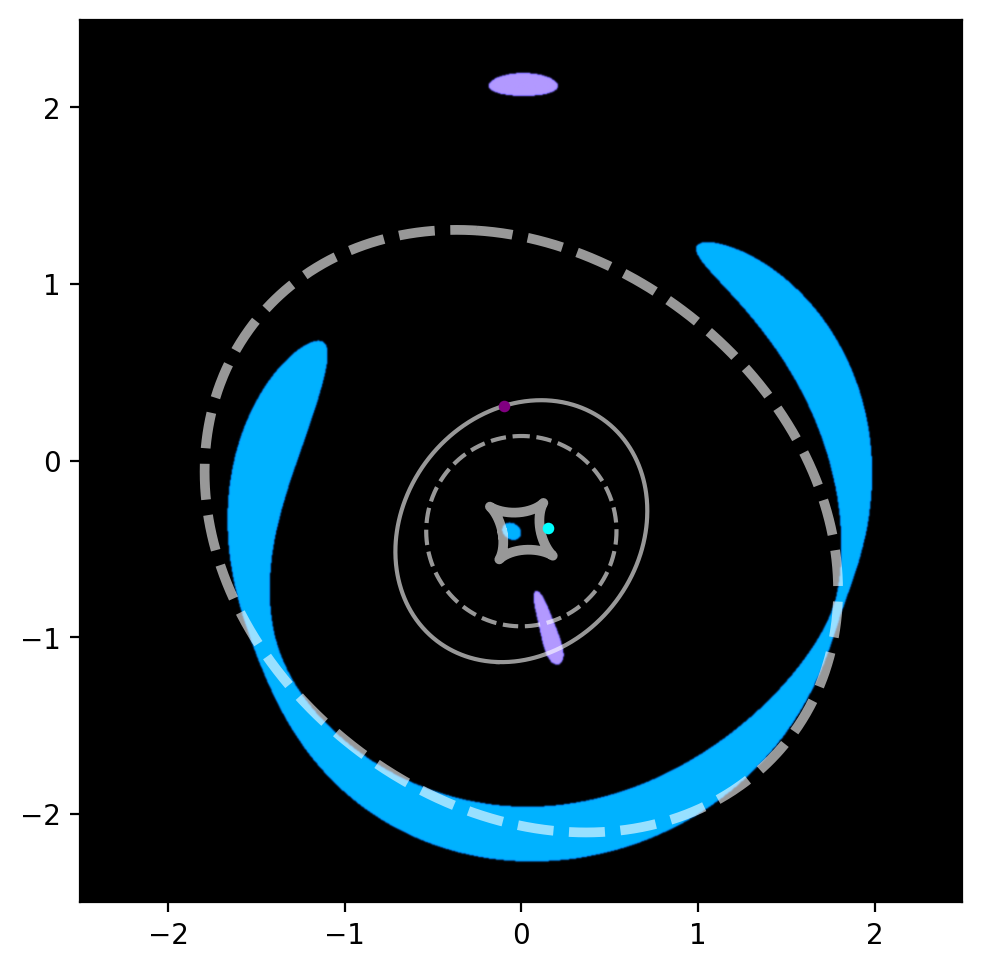

In [3]:
ra_critical_list, dec_critical_list, ra_caustic_list, dec_caustic_list \
            = modelExt.critical_curve_caustics(kwargs_lens, compute_window=np.max(imSim.Data.width), 
                                               grid_scale=deltaPix, center_x=0., center_y=0.)
# quadruply imaged source
pos1 = (0.15, -0.38)
r1 = 0.14

# doubly imaged source
pos2 = (-0.1, 0.31)
r2 = 0.06
image_pos1 = imSim.image(kwargs_lens, kwargs_source_for_pos(pos1, r=r1), kwargs_lens)
image_pos1 /= image_pos1.max()
image_pos2 = imSim.image(kwargs_lens, kwargs_source_for_pos(pos2, r=r2), kwargs_lens)
image_pos2 /= image_pos2.max()

image_rgb = np.zeros((numpix, numpix, 3))
image_rgb[:, :, 0] = 0.0 * image_pos1 + 0.7 * image_pos2
image_rgb[:, :, 1] = 0.7 * image_pos1 + 0.6 * image_pos2
image_rgb[:, :, 2] = 1.2 * image_pos1 + 1.3 * image_pos2

#x_grid_image_rs, y_grid_image_rs = imSim.LensModel.ray_shooting(x_grid_image, y_grid_image, kwargs_lens)

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
ax = axes
ax.imshow(image_rgb, extent=extent_img, origin='lower') #, norm=LogNorm(1e-3))
alpha = 0.6
ax.plot(ra_critical_list[0], dec_critical_list[0], color='white', 
        linewidth=3.5, linestyle='--', alpha=alpha, label="tangential citical line")
ax.plot(ra_critical_list[1], dec_critical_list[1], color='white', 
        linewidth=1.5, linestyle='--', alpha=alpha, label="radial citical line")
ax.plot(ra_caustic_list[0], dec_caustic_list[0], color='white',
        linewidth=3.5, linestyle='-', alpha=alpha, label="tangential caustic")
ax.plot(ra_caustic_list[1], dec_caustic_list[1], color='white',
        linewidth=1.5, linestyle='-', alpha=alpha, label="radial caustic")

# source position
ax.scatter(*pos1, c='cyan', s=10, marker='o', zorder=100)
ax.scatter(*pos2, c='purple', s=10, marker='o', zorder=100)

fig.tight_layout()
plt.show()

## Simplify and black & white for the logo

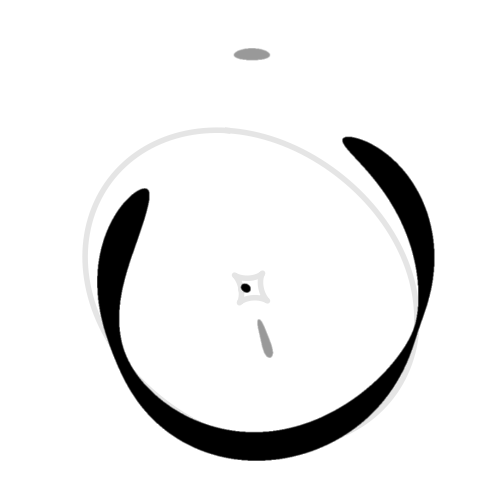

In [4]:
logo = image_pos1 + 0.4 * image_pos2
logo[logo == 0.] = np.nan

fig = plt.figure(figsize=(3, 3))
ax = plt.gca()
ax.plot(ra_critical_list[0], dec_critical_list[0], color='black', 
        linewidth=2, linestyle='-', alpha=0.1, label="tangential citical line")
ax.plot(ra_caustic_list[0], dec_caustic_list[0], color='black',
        linewidth=2, linestyle='-', alpha=0.1, label="tangential caustic")
ax.imshow(logo, extent=extent_img, origin='lower', cmap='gray_r')
ax.axis('off')
plt.show()

In [5]:
#fig.savefig(os.path.join('..', 'docs', '_static', 'coolest_logo.png'), 
#            transparent=False, dpi=300, bbox_inches='tight')